# p53 Data

In [62]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt

jax.config.update('jax_enable_x64', True)

The original data from *Barenco et al.* used a training set of $5$ known $p53$ target genes:

| **Target** | **Probeset** |
|----------|----------|
| *DDB2* | 203409_at  |
| *p21*  | 202284_s_at   |
| *SESN1/hPA26*   | 218346_s_at   |
| *BIK*   | 205780_at  |
| *TNFRSF10b*   | 209294_x_at, 209295_at, 210405_x_at   |

In [63]:
# load data from .csv files

def load_barenco_data(dir_path):
    with open(os.path.join(dir_path, 'barencoPUMA_exprs.csv'), 'r') as f:
        gene_expressions = pd.read_csv(f, index_col=0)
    with open(os.path.join(dir_path, 'barencoPUMA_se.csv'), 'r') as f:
        gene_expressions_se = pd.read_csv(f, index_col=0)

    columns = [f'cARP{r}-{t}hrs.CEL' for r in range(1, 4) for t in np.arange(7)*2]
    
    # Known genes from Barenco paper
    known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at', '211300_s_at']

    genes = gene_expressions[gene_expressions.index.isin(known_target_genes)][columns]
    genes_se = gene_expressions_se[gene_expressions_se.index.isin(known_target_genes)][columns]
    
    assert gene_expressions[gene_expressions.duplicated()].size == 0

    index = {
        '203409_at': 'DDB2',
        '202284_s_at': 'p21',
        '218346_s_at': 'SESN1',
        '205780_at': 'BIK',
        '209295_at': 'DR5',
        '211300_s_at': 'p53'
    }

    genes.rename(index=index, inplace=True)
    genes_se.rename(index=index, inplace=True)

    # Reorder genes
    genes_df = genes.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])
    genes_se = genes_se.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])

    p53_df = genes_df.iloc[-1:]
    genes_df = genes_df.iloc[:-1]
    genes = genes_df.values
    p53 = p53_df.values

    # Get variance for each gene expression value
    p53_var = genes_se.iloc[-1:].values**2
    genes_var = genes_se.iloc[:-1].values**2

    # Log-normal transormation
    p53_full = np.exp(p53 + p53_var/2)
    genes_full = np.exp(genes + genes_var/2)

    # Calculate full variance in transformed space
    p53_var_full = (np.exp(p53_var) - 1) * np.exp(2*p53 + p53_var)
    genes_var_full = (np.exp(genes_var) - 1) * np.exp(2*genes + genes_var)

    # Normalise and rescale the data
    p53_scale = np.sqrt(np.var(p53_full[:, :7], ddof=1))
    p53_scale = np.c_[[p53_scale for _ in range(7*3)]].T
    p53_expressions = np.float64(p53_full / p53_scale).reshape((3,1,7))
    p53_variances = np.float64(p53_var_full / p53_scale**2).reshape((3, 1, 7))

    genes_scale = np.sqrt(np.var(genes_full[:, :7], axis=1, ddof=1))
    genes_scale = np.c_[[genes_scale for _ in range(7*3)]].T
    genes_expressions = np.float64(genes_full / genes_scale).reshape((5,3,7)).swapaxes(0, 1)
    genes_variances = np.float64(genes_var_full / genes_scale**2).reshape((5,3,7)).swapaxes(0, 1)


    return (genes_df, genes_expressions), (p53_df, np.float64(p53_expressions)), genes_variances, p53_variances, np.arange(7)*2


In [65]:
def plot_all_genes_expression(original_df, transformed_expressions, gene_names, times):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot all original expressions on the first subplot
    for gene_name in gene_names:
        # Calculate the mean of triplicates for the original expression levels
        original_means = original_df.loc[gene_name].values.reshape(7, 3).mean(axis=1)
        axes[0].plot(times, original_means, '-o', label=gene_name)
        
    axes[0].set_title('Original Expression Levels')
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('Expression Level')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot all log-normalized expressions on the second subplot
    for i, gene_name in enumerate(gene_names):
        # Calculate the mean of triplicates for the transformed expression levels
        transformed_means = transformed_expressions[i].reshape(7, 3).mean(axis=1)
        axes[1].plot(times, transformed_means, '-o', label=gene_name)
        
    axes[1].set_title('Log-normalized Expression Levels')
    axes[1].set_xlabel('Time (hours)')
    axes[1].set_ylabel('Transformed Expression Level')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [66]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

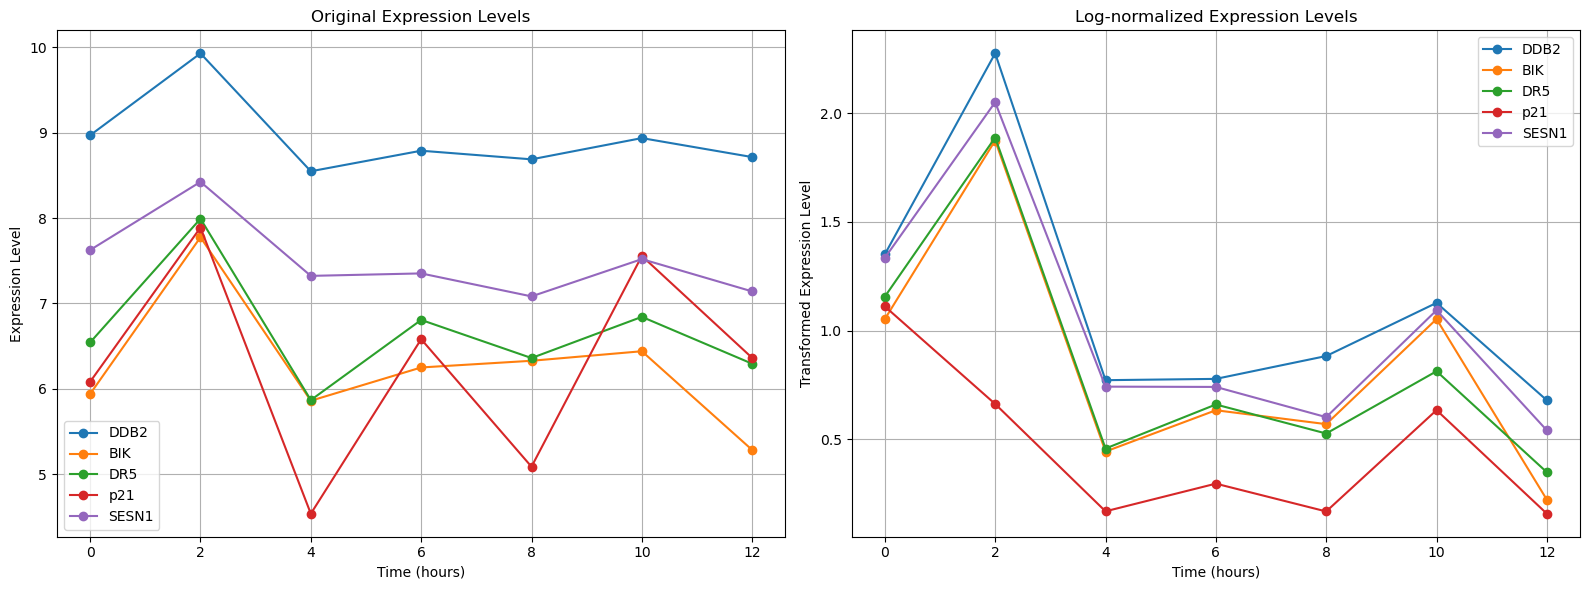

In [68]:
gene_names = ['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53']  # Assuming these are your genes of interest
plot_all_genes_expression(original_genes_df, genes_transformed.swapaxes(0, 1), gene_names[:-1], times)

## Gaussian process implementation

Now that the data has been correctly pre-processed the gaussian processes can be implemented in GPJAX

In [102]:
from p53_dataset import JAXP53_Data, flatten_dataset_jax

p53_data = JAXP53_Data(replicate=2)
train_t, train_y = flatten_dataset_jax(p53_data)

In [103]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al.
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

In [85]:
import gpjax as gpx
from jax import jit

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) 
Y = train_y.reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(kernel=kernel, mean_function=mean)
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64))
    posterior = prior * likelihood
    return posterior

# Define gp
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()
posterior = initialise_gp(kernel, mean, p53_gpjax_dataset)

# Define marginal log likelihood
mll = jit(gpx.objectives.ConjugateMLL(negative=True))


In [96]:
objective = gpx.objectives.ConjugateMLL(negative=True)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=objective,
    train_data=p53_gpjax_dataset,  # Ensure this is your GPJax Dataset instance
    max_iters=1000,  # You can adjust this number as necessary
    verbose=True,  # Set to True or False based on whether you want optimization details printed
)

c:\Users\William Purvis\.conda\envs\project_wp289\Lib\site-packages\jax\_src\numpy\lax_numpy.py:2152: RuntimeWarning: overflow encountered in cast
  out = np.array(object, dtype=dtype, ndmin=ndmin, copy=False)  # type: ignore[arg-type]


Initial loss is 2217790.1560615245


FailedScipyFitError: Optimization failed, try increasing max_iters or using a different optimiser.

In [78]:
p53_gpjax_dataset

- Number of observations: 35
- Input dimension: 1

In [97]:
# training model
import optax
from tqdm import tqdm
from gpjax.objectives import ConjugateMLL as c_mll
from jax import jit, value_and_grad

neg_log_likelihood = lambda params: -c_mll(posterior, p53_gpjax_dataset)

optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)


objective_and_grad = jit(value_and_grad(neg_log_likelihood))


num_iterations = 100
for i in tqdm(range(num_iterations)):
    loss, grads = objective_and_grad(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    if i % 10 == 0:  # print loss every 10 iterations
        print(f"Iteration {i}: NLL = {loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: AbstractObjective.__init__() takes from 1 to 2 positional arguments but 3 were given